In [1]:
import lasio
import numpy as np
import matplotlib.pyplot as plt

def merge_and_splice_curves(las_file_path, curve1_name, curve2_name, 
                            output_curve_name="MERGED", plot=True, save=True, figsize=(18, 8)):
    """
    Merge two curves from LAS file and export only the merged curve (with depth).
    Curve1 is given priority, Curve2 fills gaps.
    """

    # Load LAS
    las = lasio.read(las_file_path)
    df = las.df()
    df["DEPTH"] = df.index.astype(float)

    # Ensure required curves exist
    if curve1_name not in df.columns:
        raise KeyError(f"Curve '{curve1_name}' not found in LAS.")
    if curve2_name not in df.columns:
        raise KeyError(f"Curve '{curve2_name}' not found in LAS.")

    # Merge logic: curve1 preferred, else curve2
    merged = df[curve1_name].copy()
    merged[np.isnan(merged)] = df[curve2_name][np.isnan(merged)]
    df["MERGED"] = merged

    # ---- Export ONLY depth + merged curve ----
    if save:
        new_las = lasio.LASFile()

        # Copy a few useful well headers if present
        for key in ("STRT", "STOP", "STEP", "NULL"):
            try:
                new_las.well[key] = las.well[key]
            except KeyError:
                pass

        # Build data matrix [DEPT, MERGED] and set it (no units kwarg)
        depth = df["DEPTH"].values.astype(float)
        data = np.column_stack([depth, df["MERGED"].values.astype(float)])
        new_las.set_data(data, names=["DEPT", output_curve_name])

        # Set units/descr AFTER set_data (compat with older lasio)
        depth_unit = ""
        try:
            depth_unit = las.well.STRT.unit  # typical place depth unit lives
        except Exception:
            pass
        new_las.curves[0].unit = depth_unit
        new_las.curves[0].descr = "Depth"

        # Try to inherit unit from curve1 if available
        def unit_of(mnemonic):
            for c in las.curves:
                if c.mnemonic.strip().upper() == mnemonic.strip().upper():
                    return c.unit or ""
            return ""
        new_las.curves[1].unit = unit_of(curve1_name)
        new_las.curves[1].descr = f"Merged from {curve1_name} and {curve2_name}"

        new_file = las_file_path.replace(".las", f"_ONLY_{output_curve_name}.las")
        new_las.write(new_file)
        print(f"✅ Merged LAS with only '{output_curve_name}' saved as: {new_file}")

    # ---- Plot (shared depth + shared x-limits) ----
    if plot:
        logs = [curve1_name, curve2_name, output_curve_name]
        fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=figsize, sharey=True)
        colors = ['red', 'blue', 'black']

        all_values = np.concatenate([
            df[curve1_name].dropna().values,
            df[curve2_name].dropna().values,
            df["MERGED"].dropna().values
        ])
        xmin, xmax = np.nanmin(all_values), np.nanmax(all_values)

        for i, log in enumerate(logs):
            curve_to_plot = "MERGED" if log == output_curve_name else log
            ax[i].plot(df[curve_to_plot], df["DEPTH"], color=colors[i])
            ax[i].invert_yaxis()
            ax[i].set_title(log)
            ax[i].set_xlabel("Value")
            ax[i].set_xlim(xmin, xmax)  # same horizontal scale
            if i == 0:
                ax[i].set_ylabel("Depth")
            ax[i].grid(True)

        plt.tight_layout()
        plt.show()

    return df


Only engine='normal' can read wrapped files


✅ Merged LAS with only 'VSILT_UM' saved as: PEKAKA-1_ONLY_VSILT_UM.las


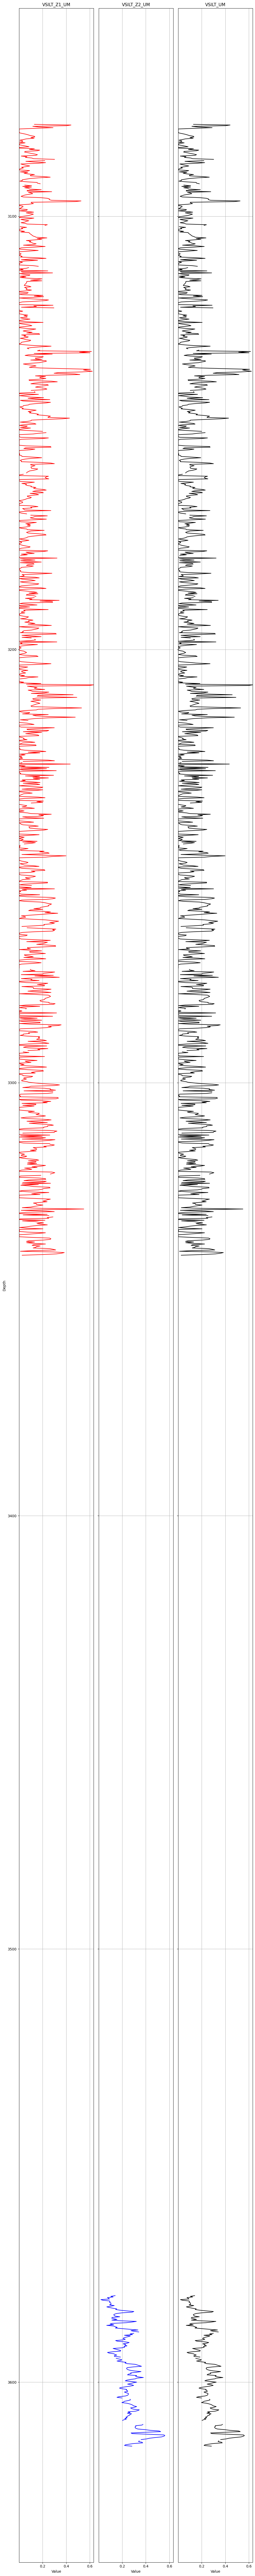

,CALI_UM,DT_UM,GR_UM,GROSS_UM,NET_UM,NPHI_UM,PAY_UM,PHIA_UM,PHIE_UM,RHOB_UM,...,VOLCANICS_UM,VSANDSTONE_Z1_UM,VSHALE_Z1_UM,VSHALE_Z2_UM,VSHL_ND_UM,VSHL_UM,VSILT_Z1_UM,VSILT_Z2_UM,DEPTH,MERGED
DEPT,,,,,,,,,,,,,,,,,,,,,
2922.1176,NaN,NaN,56.9634,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3044,NaN,NaN,2922.1176,NaN
2922.2700,NaN,NaN,62.3941,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3561,NaN,NaN,2922.2700,NaN
2922.4224,NaN,NaN,62.6077,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3581,NaN,NaN,2922.4224,NaN
2922.5748,NaN,NaN,59.8024,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3314,NaN,NaN,2922.5748,NaN
2922.7272,NaN,NaN,58.7743,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3216,NaN,NaN,2922.7272,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922.0140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3922.0140,NaN
3922.1664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3922.1664,NaN
3922.3188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3922.3188,NaN


In [43]:
las_file_path = "PEKAKA-1.las"

curve1_name = "VSILT_Z1_UM"
curve2_name = "VSILT_Z2_UM"
output_curve_name = "VSILT_UM"


merge_and_splice_curves(las_file_path, curve1_name, curve2_name, 
                            output_curve_name=output_curve_name, plot=True, save=True, figsize=(10, 100))